# Carlos Sanmiguel Vila - 07/05/2020
# Capstone Project - Machine Learning Engineer Nanodegree


# Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import catboost
import sklearn
import shap


from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import roc_auc_score


%matplotlib inline

pd.set_option('display.max_columns', None)

# Paths and Constants

In [2]:
seed = 42
sample_rate = 0.25

path = os.getcwd()
data_path = path + '/data/'
output_path = path + '/output/'


# Auxiliary Functions

In [3]:
def read_dataframe(path,sample_rate):
    """Read a portion of a Dataframe using random indices.
        Replace nan values as NaN."""
    df = pd.read_csv(path, sep=',',low_memory=True,
                     skiprows=lambda x: x > 0 and np.random.rand() > sample_rate,
                     na_values=['D19_UNBEKANNT','X', 'XX', -1])
    return df

In [4]:
def plot_nulldist(df, variable, value_range):  
    """Plot NaN distributions in a certain range."""
    df_aux = df[(df[variable]<value_range[0]) & (df[variable]>value_range[1])].dropna(how='all')
    df_aux.plot.bar(figsize=[10,10])
    plt.tick_params(axis='x', labelsize=17)
    plt.tick_params(axis='y', labelsize=17)
    plt.legend(fontsize=10)
    return 

# Exploratory Analysis

## German Population Data Sample

In [5]:
azdias_file = data_path + 'azdias.csv'
df_azdias = read_dataframe(azdias_file,sample_rate = sample_rate)

In [6]:
df_azdias.head(10)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,K

In [7]:
df_azdias.shape

(223060, 367)

In [8]:
pd.set_option('display.max_rows', None)
df_azdias.dtypes

Unnamed: 0                       int64
LNR                              int64
AGER_TYP                       float64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                

In [9]:
pd.reset_option('display.max_rows')

In [10]:
df_azdias.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
       'OST_WEST_KZ'],
      dtype='object')

## Customer Population Data Sample

In [11]:
customer_file = data_path + 'customers.csv'
df_customer = read_dataframe(customer_file,sample_rate = sample_rate)

In [12]:
df_customer.head(10)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,K

In [13]:
df_customer.shape

(47920, 370)

In [14]:
pd.set_option('display.max_rows', None)
df_customer.dtypes

Unnamed: 0                       int64
LNR                              int64
AGER_TYP                       float64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                

In [15]:
df_customer.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
       'OST_WEST_KZ', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

### Check intersection of the features

In [16]:
diff_customer = set(df_customer.columns).difference(df_azdias.columns)
print(diff_customer)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}


In [17]:
diff_azdias = set(df_azdias.columns).difference(df_customer.columns)
print(diff_azdias)

set()


### Summary

For this analysis it has been considered as NaN value the values of ['D19_UNBEKANNT','X', 'XX', -1]. 

The feature type is distributed as follows:

-	float 64 273 features
-	int64 90 features
-	object 4 features

It has to be remarked that most of the features are categorical.

The columns ['CUSTOMER_GROUP', 'PRODUCT_GROUP', ‘ONLINE_PURCHASE'] are exclusive from the Customer dataset.

The features ['LNR', 'EINGEFUEGT_AM'] are related with index data and insertion date. Therefore, they are not relevant.

There are a high number of NaN values that should be analyzed.

## NaN Analysis

In [18]:
df_cust_null = df_customer.isna().sum()/df_customer.shape[0]
df_cust_null = df_cust_null.drop(list(diff_customer))

In [19]:
df_azdias_null = df_azdias.isna().sum()/df_azdias.shape[0]

In [20]:
df_null = pd.concat([df_cust_null, df_azdias_null], join='inner', sort=True, axis=1)
df_null.columns = ['customers','azdias']
df_null= df_null[df_null>0].dropna(how='all').sort_values(by ='customers' )

In [21]:
df_null.head()

,customers,azdias
HH_EINKOMMEN_SCORE,0.015693,0.020595
CJT_TYP_2,0.016611,0.005474
CJT_TYP_1,0.016611,0.005474
CJT_KATALOGNUTZER,0.016611,0.005474
CJT_GESAMTTYP,0.016611,0.005474


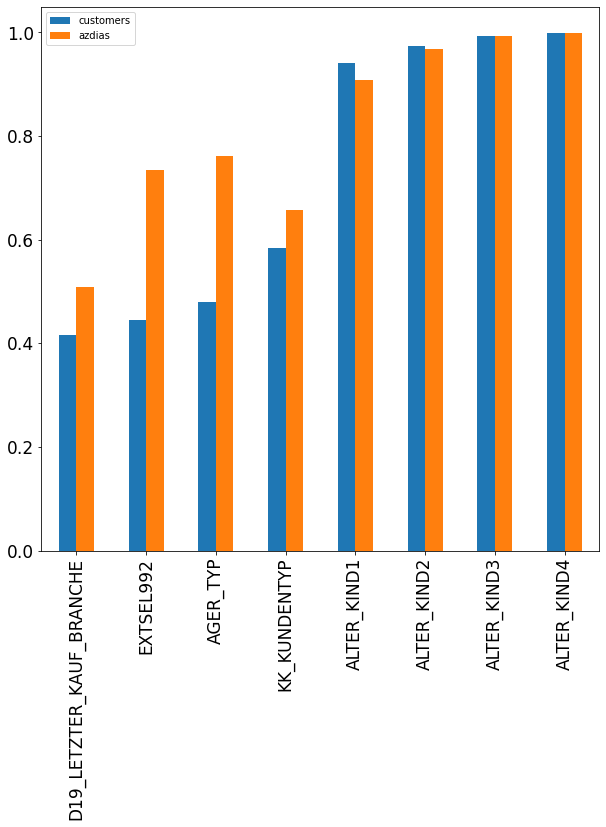

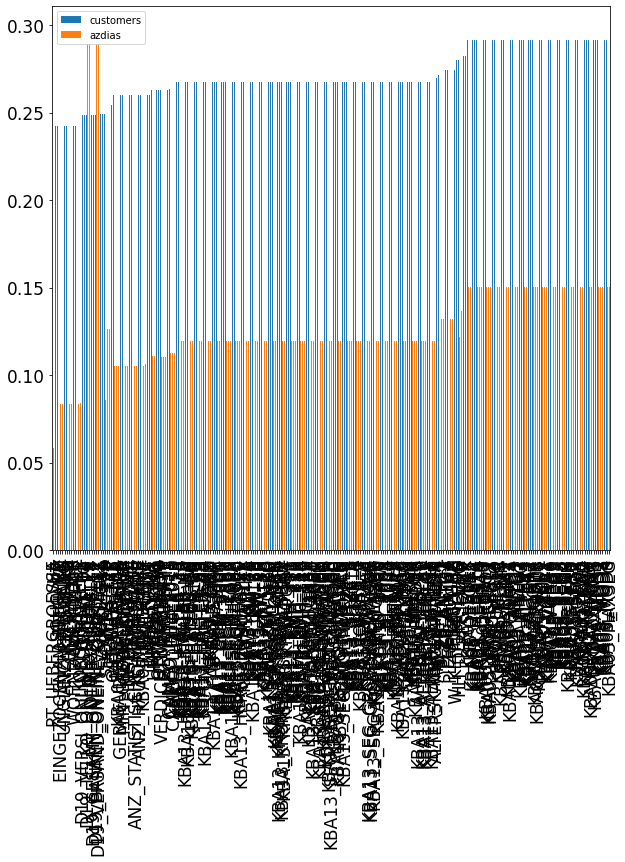

In [22]:
null_range = [[1,0.4], [0.4,0.20]]
for null_step in null_range:
    plot_nulldist(df_null, 'customers', null_step)

In [23]:
df_null['null_diff'] = abs(df_null['customers']-df_null['azdias'])

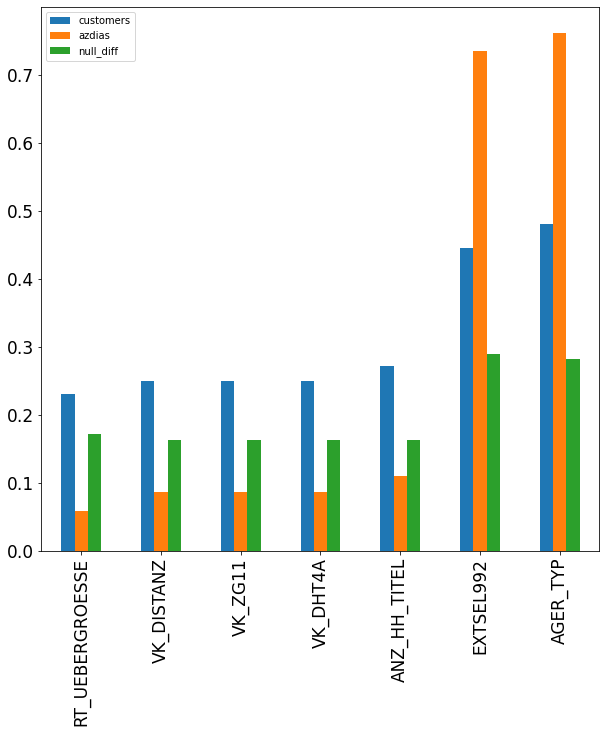

In [24]:
plot_nulldist(df_null, 'null_diff', [1,0.16])

In [25]:
null_limit = 0.4
null_columns_04 = list(df_null[np.logical_or(df_null['customers']>null_limit, df_null['azdias']>null_limit)].index)
print(null_columns_04)

null_limit = 0.6
null_columns_06 = list(df_null[np.logical_or(df_null['customers']>null_limit, df_null['azdias']>null_limit)].index)
print(null_columns_06)

['D19_LETZTER_KAUF_BRANCHE', 'EXTSEL992', 'AGER_TYP', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']
['EXTSEL992', 'AGER_TYP', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']


### Summary

It looks that the null distribution is quite similar in both dataframe although there is a high level of NaN values in the customer dataset.

The features with a certain level of NaNs are saved to be dropped in following model stages.

# Data Preprocessing

In [26]:
drop_columns = ['Unnamed: 0','LNR','EINGEFUEGT_AM'] + list(diff_customer)
drop_columns044 = list(df_null[df_null>0.4].index)


In [27]:
df_customer = df_customer.drop(columns=drop_columns, errors='ignore')
df_azdias = df_azdias.drop(columns=drop_columns, errors='ignore')

In [28]:
diff_customer_drop = set(df_customer.columns).difference(df_azdias.columns)
print(diff_customer_drop)
diff_azdias_drop = set(df_azdias.columns).difference(df_customer.columns)
print(diff_azdias_drop)

set()
set()


In [29]:
df_azdias = df_azdias.assign(arvato=0)
df_customer = df_customer.assign(arvato=1)

df = pd.concat([df_azdias, df_customer], join='inner', axis=0)

df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [30]:
df.tail()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [31]:
df.shape

(270980, 365)

In [32]:
X = df.drop(columns=['arvato']).fillna(-999, downcast=False)
y = df['arvato']

cat_features = X.select_dtypes(include='object').columns

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

### Summary

-	NaN values have been replaced to 999 values in order to configure CatBoost to get minimal values as null ones.

-	Features which are not present in both dataset (German Population and Customers) are dropped ('CUSTOMER_GROUP', 'PRODUCT_GROUP', ‘ONLINE_PURCHASE').

-	Features which do not include any relevant information such as index data or insertion date are also dropped (‘LNR’, ‘EINGEFUEGT_AM’).

-	Features which have a high number of NaN values are characterized.

-	df dataframe is created combining both dataset (German Population and Customers)

-	Feature 'arvato' is created to classify which rows are from Customers (1) or German Population (0) dataframe.


In [33]:
model_train = CatBoostClassifier(n_estimators=45,
                                 max_depth=3,
                                 loss_function='Logloss',
                                 nan_mode='Min',
                                 custom_metric=['AUC'],
                                 random_state=seed)



model_train.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.5
0:	learn: 0.3489642	total: 316ms	remaining: 13.9s
1:	learn: 0.2910224	total: 584ms	remaining: 12.6s
2:	learn: 0.2726692	total: 848ms	remaining: 11.9s
3:	learn: 0.2639383	total: 1.12s	remaining: 11.5s
4:	learn: 0.2566896	total: 1.36s	remaining: 10.9s
5:	learn: 0.2545806	total: 1.58s	remaining: 10.3s
6:	learn: 0.2528549	total: 1.84s	remaining: 9.98s
7:	learn: 0.2511603	total: 2.12s	remaining: 9.8s
8:	learn: 0.2495354	total: 2.35s	remaining: 9.4s
9:	learn: 0.2488230	total: 2.59s	remaining: 9.08s
10:	learn: 0.2475850	total: 2.85s	remaining: 8.81s
11:	learn: 0.2471218	total: 3.1s	remaining: 8.53s
12:	learn: 0.2457155	total: 3.34s	remaining: 8.22s
13:	learn: 0.2447076	total: 3.56s	remaining: 7.89s
14:	learn: 0.2441206	total: 3.85s	remaining: 7.7s
15:	learn: 0.2436462	total: 4.11s	remaining: 7.46s
16:	learn: 0.2432009	total: 4.34s	remaining: 7.16s
17:	learn: 0.2428761	total: 4.6s	remaining: 6.91s
18:	learn: 0.2426658	total: 4.85s	remaining: 6.63s
19:	learn: 0.2422074	

In [34]:
predict = model_train.predict(X_test)
predict_proba = model_train.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, predict_proba)
auc

0.9312845489553631

### Summary

A Catboost model is implemented successfully. This model will be used to make a first prediction with the Kaggle data. 

# Kaggle Competition

### Kaggle Train Data Preprocessing

In [35]:
train_kaggle = data_path + 'mailout_train.csv'
df_train = read_dataframe(train_kaggle,sample_rate = 1)
df_train_index = df_train['LNR']
df_train.head(10)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,K

In [36]:
drop_columns = ['Unnamed: 0','LNR','EINGEFUEGT_AM'] + list(diff_customer)

df_train = df_train.drop(columns=drop_columns, errors='ignore')

In [37]:
X_kag = df_train.drop(columns=['RESPONSE']).fillna(-999, downcast=False)
y_kag = df_train['RESPONSE']

cat_features_kag = X_kag.select_dtypes(include='object').columns


## Model 1
Predict using the model obtained with the previous dataset

In [38]:
predict = model_train.predict(X_kag)
predict_proba = model_train.predict_proba(X_kag)[:, 1]

auc = roc_auc_score(y_kag, predict_proba)
auc

0.7503997074349792

## Model 2

Fit a new model using the same hyperparameters but using the Kaggle dataset

In [39]:
model_train_kag_2 = CatBoostClassifier(n_estimators=45,
                                 max_depth=3,
                                 loss_function='Logloss',
                                 nan_mode='Min',
                                 custom_metric=['AUC'],
                                 random_state=seed)



model_train_kag_2.fit(X_kag, y_kag, cat_features=cat_features_kag)

Learning rate set to 0.5
0:	learn: 0.1329737	total: 83ms	remaining: 3.65s
1:	learn: 0.0772750	total: 152ms	remaining: 3.27s
2:	learn: 0.0686190	total: 225ms	remaining: 3.15s
3:	learn: 0.0621474	total: 301ms	remaining: 3.08s
4:	learn: 0.0613376	total: 369ms	remaining: 2.95s
5:	learn: 0.0612871	total: 422ms	remaining: 2.74s
6:	learn: 0.0612447	total: 483ms	remaining: 2.62s
7:	learn: 0.0612247	total: 539ms	remaining: 2.49s
8:	learn: 0.0601821	total: 617ms	remaining: 2.47s
9:	learn: 0.0601607	total: 678ms	remaining: 2.37s
10:	learn: 0.0599260	total: 745ms	remaining: 2.3s
11:	learn: 0.0598176	total: 826ms	remaining: 2.27s
12:	learn: 0.0596861	total: 903ms	remaining: 2.22s
13:	learn: 0.0596031	total: 975ms	remaining: 2.16s
14:	learn: 0.0594751	total: 1.05s	remaining: 2.11s
15:	learn: 0.0593090	total: 1.12s	remaining: 2.04s
16:	learn: 0.0591227	total: 1.2s	remaining: 1.97s
17:	learn: 0.0589472	total: 1.25s	remaining: 1.88s
18:	learn: 0.0588724	total: 1.33s	remaining: 1.82s
19:	learn: 0.058697

In [40]:
predict_2 = model_train_kag_2.predict(X_kag)
predict_proba_2 = model_train_kag_2.predict_proba(X_kag)[:, 1]

auc = roc_auc_score(y_kag, predict_proba_2)
auc

0.8447353580155905

### Kaggle Test Data Preprocessing

In [41]:
test_kaggle = data_path + 'mailout_test.csv'
df_test = read_dataframe(test_kaggle,sample_rate = 1)
df_test_index = df_test['LNR']
df_test.head(10)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,K

In [42]:
drop_columns_2 = ['Unnamed: 0','LNR','EINGEFUEGT_AM'] + list(diff_customer)
df_test = df_test.drop(columns=drop_columns_2, errors='ignore')
X_kag_test = df_test.fillna(-999, downcast=False)
predict_proba_2 = model_train_kag_2.predict_proba(X_kag_test)[:, 1]

In [43]:
prediction = pd.DataFrame(predict_proba_2, columns=['RESPONSE'])

In [44]:
kaggle_sub = pd.concat([df_test_index, prediction], axis=1)
kaggle_nam = output_path + 'sanmiguel_catboost1.csv'
kaggle_sub.to_csv(kaggle_nam, index=False)

kaggle_sub.head()


,LNR,RESPONSE
0,1754,0.040165
1,1770,0.037117
2,1465,0.019744
3,1470,0.002242
4,1478,0.003023


In [45]:
kaggle_sub.shape

(42833, 2)

## Model 3

Model 2 with a reduced learning rate 

**Best Kaggle Submission**

In [46]:
model_train_kag_3 = CatBoostClassifier(n_estimators=45,
                                 max_depth=3,
                                 loss_function='Logloss',
                                 nan_mode='Min',
                                 custom_metric=['AUC'],
                                 random_state=seed,
                                 eta = 0.25)



model_train_kag_3.fit(X_kag, y_kag, cat_features=cat_features_kag)

0:	learn: 0.3017571	total: 186ms	remaining: 8.21s
1:	learn: 0.1607592	total: 294ms	remaining: 6.32s
2:	learn: 0.1075241	total: 417ms	remaining: 5.83s
3:	learn: 0.0855804	total: 511ms	remaining: 5.23s
4:	learn: 0.0758521	total: 607ms	remaining: 4.85s
5:	learn: 0.0672176	total: 718ms	remaining: 4.67s
6:	learn: 0.0654875	total: 819ms	remaining: 4.44s
7:	learn: 0.0645747	total: 921ms	remaining: 4.26s
8:	learn: 0.0621783	total: 1.02s	remaining: 4.07s
9:	learn: 0.0620058	total: 1.09s	remaining: 3.83s
10:	learn: 0.0612452	total: 1.18s	remaining: 3.64s
11:	learn: 0.0611934	total: 1.24s	remaining: 3.4s
12:	learn: 0.0606244	total: 1.33s	remaining: 3.28s
13:	learn: 0.0604968	total: 1.4s	remaining: 3.1s
14:	learn: 0.0604787	total: 1.46s	remaining: 2.92s
15:	learn: 0.0604627	total: 1.55s	remaining: 2.81s
16:	learn: 0.0604498	total: 1.62s	remaining: 2.66s
17:	learn: 0.0603229	total: 1.69s	remaining: 2.53s
18:	learn: 0.0603127	total: 1.76s	remaining: 2.41s
19:	learn: 0.0602860	total: 1.82s	remaining:

In [47]:
predict_3 = model_train_kag_3.predict(X_kag)
predict_proba_3 = model_train_kag_3.predict_proba(X_kag)[:, 1]

auc = roc_auc_score(y_kag, predict_proba_3)
auc

0.8220903425190361

In [48]:
predict_proba_3 = model_train_kag_3.predict_proba(X_kag_test)[:, 1]
prediction_3 = pd.DataFrame(predict_proba_3, columns=['RESPONSE'])
kaggle_sub = pd.concat([df_test_index, prediction_3], axis=1)
kaggle_nam = output_path + 'sanmiguel_catboost2.csv'
kaggle_sub.to_csv(kaggle_nam, index=False)

kaggle_sub.head()
model_nam = output_path + 'catboost_kaggle.model'
model_train_kag_3.save_model(model_nam)

## Model 4

Model 3 using class_weights

In [49]:
class_weights = (1, sum(y_kag == 0) / sum(y_kag == 1))

model_train_kag_4 = CatBoostClassifier(n_estimators=45,
                                 max_depth=3,
                                 loss_function='Logloss',
                                 nan_mode='Min',
                                 custom_metric=['AUC'],
                                 random_state=seed,
                                 class_weights= class_weights,
                                 eta = 0.25)



model_train_kag_4.fit(X_kag, y_kag, cat_features=cat_features_kag)

0:	learn: 0.6369995	total: 96.1ms	remaining: 4.23s
1:	learn: 0.6071867	total: 172ms	remaining: 3.7s
2:	learn: 0.5859968	total: 231ms	remaining: 3.24s
3:	learn: 0.5803985	total: 345ms	remaining: 3.54s
4:	learn: 0.5736655	total: 421ms	remaining: 3.37s
5:	learn: 0.5702208	total: 489ms	remaining: 3.18s
6:	learn: 0.5688688	total: 557ms	remaining: 3.02s
7:	learn: 0.5675628	total: 656ms	remaining: 3.03s
8:	learn: 0.5657407	total: 721ms	remaining: 2.88s
9:	learn: 0.5614523	total: 816ms	remaining: 2.86s
10:	learn: 0.5570965	total: 903ms	remaining: 2.79s
11:	learn: 0.5557731	total: 978ms	remaining: 2.69s
12:	learn: 0.5537356	total: 1.06s	remaining: 2.6s
13:	learn: 0.5527226	total: 1.14s	remaining: 2.53s
14:	learn: 0.5512603	total: 1.24s	remaining: 2.47s
15:	learn: 0.5485824	total: 1.3s	remaining: 2.36s
16:	learn: 0.5470779	total: 1.37s	remaining: 2.26s
17:	learn: 0.5457039	total: 1.44s	remaining: 2.16s
18:	learn: 0.5446037	total: 1.5s	remaining: 2.05s
19:	learn: 0.5413325	total: 1.57s	remaining:

In [50]:
predict_4 = model_train_kag_4.predict(X_kag)
predict_proba_4 = model_train_kag_4.predict_proba(X_kag)[:, 1]

auc = roc_auc_score(y_kag, predict_proba_4)
auc

0.8379580077934644

In [51]:
predict_proba_4 = model_train_kag_4.predict_proba(X_kag_test)[:, 1]
prediction_4 = pd.DataFrame(predict_proba_4, columns=['RESPONSE'])
kaggle_sub = pd.concat([df_test_index, prediction_4], axis=1)
kaggle_nam = output_path + 'sanmiguel_catboost3.csv'
kaggle_sub.to_csv(kaggle_nam, index=False)


## Model 5

Model 3 dropping features with at least 40% of NaN

In [52]:
X_kag_dropnull = X_kag.drop(columns=null_columns_04)

cat_features_kag_null = X_kag_dropnull.select_dtypes(include='object').columns


model_train_kag_5 = CatBoostClassifier(n_estimators=45,
                                 max_depth=3,
                                 loss_function='Logloss',
                                 nan_mode='Min',
                                 custom_metric=['AUC'],
                                 random_state=seed,
                                 eta = 0.25)



model_train_kag_5.fit(X_kag_dropnull, y_kag, cat_features=cat_features_kag_null)

0:	learn: 0.3016180	total: 119ms	remaining: 5.24s
1:	learn: 0.1607228	total: 188ms	remaining: 4.04s
2:	learn: 0.1075956	total: 252ms	remaining: 3.52s
3:	learn: 0.0856913	total: 327ms	remaining: 3.35s
4:	learn: 0.0759569	total: 399ms	remaining: 3.19s
5:	learn: 0.0712229	total: 497ms	remaining: 3.23s
6:	learn: 0.0676280	total: 579ms	remaining: 3.14s
7:	learn: 0.0641660	total: 641ms	remaining: 2.96s
8:	learn: 0.0623164	total: 712ms	remaining: 2.85s
9:	learn: 0.0617521	total: 827ms	remaining: 2.9s
10:	learn: 0.0612278	total: 920ms	remaining: 2.84s
11:	learn: 0.0611843	total: 987ms	remaining: 2.71s
12:	learn: 0.0611411	total: 1.06s	remaining: 2.62s
13:	learn: 0.0610677	total: 1.15s	remaining: 2.56s
14:	learn: 0.0610492	total: 1.24s	remaining: 2.49s
15:	learn: 0.0610289	total: 1.32s	remaining: 2.39s
16:	learn: 0.0610191	total: 1.39s	remaining: 2.29s
17:	learn: 0.0606852	total: 1.47s	remaining: 2.2s
18:	learn: 0.0601716	total: 1.55s	remaining: 2.12s
19:	learn: 0.0601636	total: 1.61s	remaining

In [53]:
predict_5 = model_train_kag_5.predict(X_kag_dropnull)
predict_proba_5 = model_train_kag_5.predict_proba(X_kag_dropnull)[:, 1]

auc = roc_auc_score(y_kag, predict_proba_5)
auc

0.815389877002192

In [54]:
X_kag_test_null = X_kag_test.drop(columns=null_columns_04)

predict_proba_5 = model_train_kag_5.predict_proba(X_kag_test_null)[:, 1]
prediction_5 = pd.DataFrame(predict_proba_5, columns=['RESPONSE'])
kaggle_sub = pd.concat([df_test_index, prediction_5], axis=1)
kaggle_nam = output_path + 'sanmiguel_catboost4.csv'
kaggle_sub.to_csv(kaggle_nam, index=False)


## Model Evaluation and Validation

### Cross-validation with 5 folds

In [55]:
auc_scores = []
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

for tr_ind, val_ind in skf.split(X_kag, y_kag):
    X_train = X_kag.iloc[tr_ind]
    y_train = y_kag.iloc[tr_ind]

    X_valid = X_kag.iloc[val_ind]
    y_valid = y_kag.iloc[val_ind]

    model = CatBoostClassifier(n_estimators=45,
                                 max_depth=3,
                                 loss_function='Logloss',
                                 nan_mode='Min',
                                 custom_metric=['AUC'],
                                 random_state=seed,
                                 eta = 0.25,
                                 logging_level='Silent'
    )

    model.fit(X_train, 
            y_train,
            cat_features=cat_features_kag,
            eval_set=(X_valid, y_valid)
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    auc_scores.append(auc) 
    
sum(auc_scores)/n_splits

0.7696466486047553

### Shap features

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


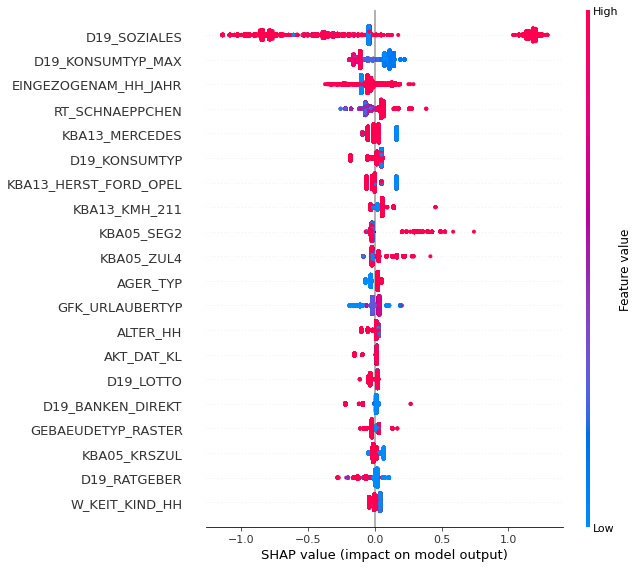

In [56]:
explainer = shap.TreeExplainer(model_train_kag_3)
shap_values = explainer.shap_values(X_kag)

shap.summary_plot(shap_values, X_kag)

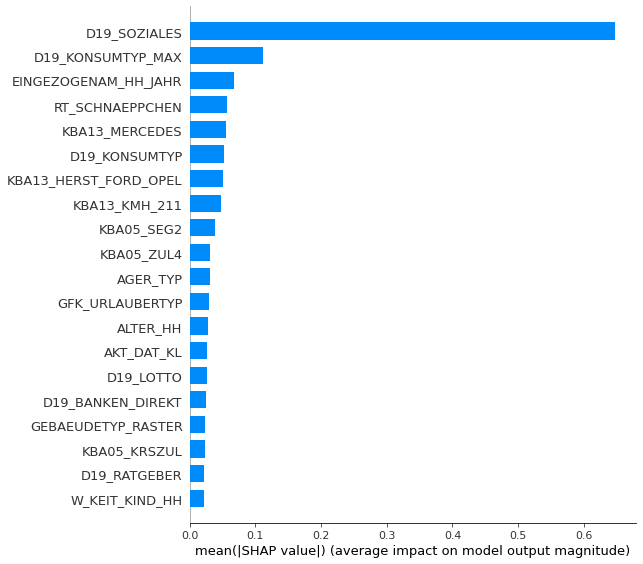

In [57]:
shap.summary_plot(shap_values, X_kag, plot_type='bar')